In [2]:
###
# Idea for pretty art from images. 
# image is gaussian blurred into a potential, 
#lines emerge from edges and are attracted to the image basin. Lines per channel 

In [1]:
import os
import numpy as np
import imageio
from PIL import Image
from matplotlib import pyplot as plt
from scipy import interpolate

from math import sqrt, pow, cos, sin, pi
import copy, pickle, random

%matplotlib inline

In [139]:
import svgwrite

In [46]:
files = os.listdir('/Users/johnparkhill/Little_Projects/art_for_lines')

In [49]:
rootdir = '/Users/johnparkhill/Little_Projects/art_for_lines/'
im_arrays=[]
for X in files: 
    if X.count("jpg")>0: 
        with open(rootdir+X,'rb') as f: 
            im_arrays.append(imageio.imread(f))

In [47]:
files

['stalkerII.svg',
 'Gmail - UPS Ship Notification, Tracking Number 1Z71EY050398294688.pdf',
 'drawing.svg',
 '.DS_Store',
 'bob_le_flambeur-900.jpg',
 '81E3dK1i3-L._SL1500_.jpg',
 'CE3_stepper_motor_mount.3mf',
 'stalker-1979-002-00m-ln4-dog-running-through-water_0.jpg',
 'gokudo-kyofu-dai-gekijo-gozu-german-dvd-movie-cover.jpg',
 '23405756_1890470151282571_8743520120236682996_o.jpg',
 'StalkerII.png',
 'e62edc39b7fafd0edf295b833bbcc5a3.jpg',
 'images-w1400.jpg',
 'LDurieux_Conversation_Var_Sm_1024x1024.png',
 'jobbetter.jpg',
 'Gmail - Order Confirmation No_ 2165847-6155262135.pdf',
 'tJaeWoH1UJPyeIU2yd9YJgeghFC.jpg',
 'otto-e-mezzo-8-1-2-movie-fellini-eleven.png',
 'python_polargraph',
 'img_1298.jpg']

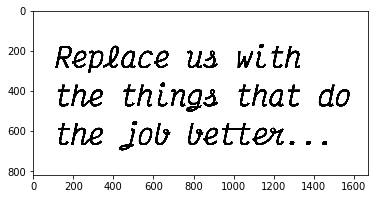

In [52]:
img = im_arrays[-3]
plt.imshow(img)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


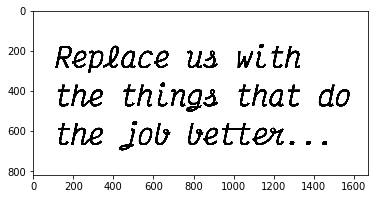

In [53]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 1.0
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)

In [55]:
def floyd_steinberg(X, mx=255., alg = 'stucki'):
    """
    output is 1 or zero. 
    """
    rank = len(X.shape)
    if (rank==2):
        out = np.zeros((X.shape[0]+4, X.shape[1]+4))
    elif (rank==3):
        out = np.zeros((X.shape[0]+4, X.shape[1]+4, X.shape[2]))
    errors = np.zeros(out.shape)
    xdim = X.shape[0]
    ydim = X.shape[1]
    if (alg == 'stucki'):
        error_array = np.array([[0.,0.,0,8,4],[2.,4.,8,4,2],[1.,2.,4,2,1]])/42.
    else: 
        error_array = np.array([[0.,0.,0,1,1],[0.,1.,1,1,0],[0.,0.,1,0,0]])/8.
    for y in range(2,ydim+2):
        for x in range(2,xdim+2):
            div = X[x-2,y-2].astype(np.float64)/mx + errors[x,y] 
            output = np.round(div)
            error = div - output
            out[x,y] = output
            if (rank == 2):
                errors[x-2:x+3,y:y+3] += error * error_array.T
            else: 
                errors[x-2:x+3,y:y+3] += error * error_array[:,:,np.newaxis].transpose(1,0,2)
    return out[2:-2,2:-2]

def rgb_to_cmyk(X, RGB_SCALE = 255):
    CMYK_SCALE = 1.
    r = X[:,:,0].astype(np.float64)
    g = X[:,:,1].astype(np.float64)
    b = X[:,:,2].astype(np.float64)
    # rgb [0,255] -> cmy [0,1]
    c = 1. - r / RGB_SCALE
    m = 1. - g / RGB_SCALE
    y = 1. - b / RGB_SCALE
    # extract out k [0, 1]
    #     min_cmy = min(c, m, y)
    min_cmy = np.minimum(c, m)
    min_cmy = np.minimum(min_cmy, y)
    k = np.where(r+g+b == 0, 1., min_cmy)
    c = (c - min_cmy) / (1. - min_cmy+1e-9)
    m = (m - min_cmy) / (1. - min_cmy+1e-9)
    y = (y - min_cmy) / (1. - min_cmy+1e-9)
    # rescale to the range [0,CMYK_SCALE]
    return np.stack([c * CMYK_SCALE, y * CMYK_SCALE, m * CMYK_SCALE,  k * CMYK_SCALE], -1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


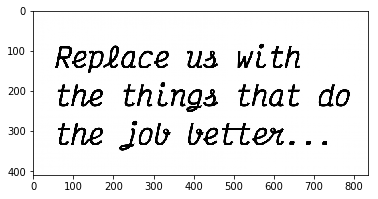

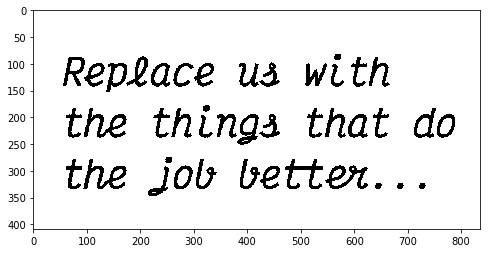

In [56]:
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
#
# 2x oversample the image since we'll dither it. 
#
oversamp = 0.5
xnew = np.linspace(0, img.shape[0], img.shape[0]*oversamp)
ynew = np.linspace(0, img.shape[1], img.shape[1]*oversamp)
rc = interpolate.interp2d(x, y, img[:,:,0].flatten(), kind='linear')
gc = interpolate.interp2d(x, y, img[:,:,1].flatten(), kind='linear')
bc = interpolate.interp2d(x, y, img[:,:,2].flatten(), kind='linear')
rgb_new = np.stack([rc(xnew.flatten(), ynew.flatten()),
                    gc(xnew.flatten(), ynew.flatten()),
                    bc(xnew.flatten(), ynew.flatten())],-1).transpose(1,0,2).astype(np.uint8)
plt.imshow(rgb_new)
# cymk_new = rgb_to_cymk(rgb_new)
dith_r = floyd_steinberg(rgb_new)
plt.figure(figsize=(8,10))
plt.imshow((255*dith_r).astype(np.uint8))

In [57]:
## Render a dithered image as polygons
def ngon(X=0, Y=0, r=1, n=6, phase = 0, closed = True):
    pts = []
    step = 2*pi/n
    for K in range(n): 
        pts.append([X+r*cos(K*step+phase),
                    Y+r*sin(K*step+phase)])
    if closed: 
        pts.append([X+r*cos(phase),
                    Y+r*sin(phase)])
    return pts

def random_ngon_linify(cymk_img, n_min=3, n_max=6, r_min = .1, r_max = 1.):
    """
    Draws ngons over a previously dithered image. 
    """
    c_lines, y_lines, m_lines, k_lines = [],[],[],[] 
    for X in range(cymk_img.shape[0]): 
        for Y in range(cymk_img.shape[1]): 
            if (cymk_img[X,Y,0]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                c_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,1]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                y_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,2]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                m_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))
            if (cymk_img[X,Y,3]>0.5):
                R = random.random()*(r_max-r_min) + r_min
                NN = random.randint(n_min,n_max)
                phase = random.random()*2*pi
                k_lines.append(ngon(X,Y,r=R,n=NN,phase=phase))                
    return c_lines, y_lines, m_lines, k_lines

In [143]:
#
# Idea: projection of 3d paths. 
# First make a wiggle, then z-project it. 
# tilt then 2d project. 
#
def lerp(p0,p1,npts = 300):
    a = np.linspace(0,1,npts)
    L=(1.-a[:,np.newaxis])*np.array(p0)[np.newaxis,:]+a[:,np.newaxis]*np.array(p1)[np.newaxis,:]
    return L.tolist()
def wiggle_fill(x_dim, y_dim, nwiggle = 80, npts=300): 
    paths = []
    Xs = np.linspace(x_dim[0],x_dim[1],nwiggle)
    Ys = np.linspace(y_dim[0],y_dim[1],nwiggle)
    last_vertex = (Xs[0],Ys[0])
    d='r'
    N = 1
    while N < nwiggle-1: 
        if (d == 'ld'):
            paths.extend(lerp(last_vertex, (Xs[0], Ys[N]),npts = npts))
            last_vertex = (Xs[0], Ys[N])
            d ='d'
        elif (d == 'd'):
            N+=1
            paths.extend(lerp(last_vertex, (Xs[0], Ys[N]),npts = npts))
            last_vertex = (Xs[0], Ys[N])
            d = 'ur'            
        elif (d == 'ur'):
            paths.extend(lerp(last_vertex, (Xs[N], Ys[0]),npts = npts))
            last_vertex = (Xs[N], Ys[0])
            d = 'r'            
        elif (d=='r'):
            N+=1
            paths.extend(lerp(last_vertex, (Xs[N], Ys[0]),npts = npts))
            last_vertex = (Xs[N], Ys[0])
            d = 'ld'
    N = 0
    d='ur'
    while N < nwiggle-1: 
        if (d == 'ld'):
            paths.extend(lerp(last_vertex, (Xs[N], Ys[-1]),npts = npts))
            last_vertex = (Xs[N], Ys[-1])
            d ='r'
        elif (d == 'd'):
            N+=1
            paths.extend(lerp(last_vertex, (Xs[-1], Ys[N]),npts = npts))
            last_vertex = (Xs[-1], Ys[N])
            d = 'ld'            
        elif (d == 'ur'):
            paths.extend(lerp(last_vertex, (Xs[-1], Ys[N]),npts = npts))
            last_vertex = (Xs[-1], Ys[N])
            d = 'd'            
        elif (d=='r'):
            N+=1
            paths.extend(lerp(last_vertex, (Xs[N], Ys[-1]),npts = npts))
            last_vertex = (Xs[N], Ys[-1])
            d = 'ur'            
    return paths
def path_channel_distort(path,F): 
    """
    Moves points in a path per a channel... 
    """
    new_path = []
    for vertex in path: 
        z = F(*vertex)
        new_path.append([vertex[0]+3*z,vertex[1]+3*z])
    return new_path

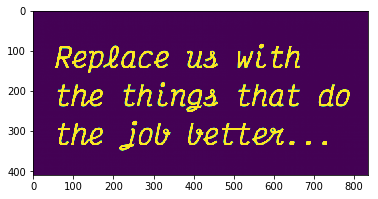

(57900, 2)


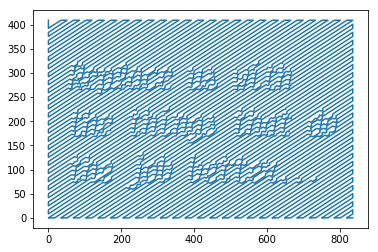

In [144]:
img = rgb_to_cmyk(rgb_new, RGB_SCALE=255.)[:,:,-1]
plt.imshow(img)
plt.show()
x = np.linspace(0, img.shape[0], img.shape[0])
y = np.linspace(0, img.shape[1], img.shape[1])
F = interpolate.interp2d(x, y, img.flatten(), kind='linear')
new_path = path_channel_distort(wiggle_fill((0,img.shape[0]),(0,img.shape[1]),nwiggle=50),F)
P = np.array(new_path).reshape(-1,2)
print(P.shape)
plt.plot(P[:,1]-P[:,1].min(),-1*P[:,0]+P[:,0].max())
plt.show()

In [145]:
# Check the SVG before plotting it out. 
write_svg([P.tolist()])

In [147]:
with open("jobbetter.pkl",'wb') as f: 
    pickle.dump([P],f)

In [47]:
dithered = floyd_steinberg(rgb_new)
# Because the dithered output is already between 0,1
cymk_new = rgb_to_cmyk(dithered, RGB_SCALE=1.)
c_lines, y_lines, m_lines, k_lines = random_ngon_linify(cymk_new)
cymk_lines = [c_lines, y_lines, m_lines, k_lines]

In [137]:
def write_svg(lines, outname="dump", scale = 1.0): 
    dwg = svgwrite.Drawing(outname+'.svg')
    for line in lines:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line(line[I][::-1], line[I+1][::-1], stroke=svgwrite.rgb(0, 0, 0, '%')))            
    dwg.save()
    
def cymk_to_svg(lines, outname="dump", scale = 1.0): 
    dwg = svgwrite.Drawing(outname+'.svg')
    for line in lines[0]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                             (scale*line[I+1][1],scale*line[I+1][0]),
                             stroke=svgwrite.rgb(0, 100, 100, '%')))
    for line in lines[1]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]),
                            stroke=svgwrite.rgb(100, 100, 0, '%')))
    for line in lines[2]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]), 
                             stroke=svgwrite.rgb(100, 0, 100, '%')))
    for line in lines[3]:
        if (len(line)<2):
            continue 
        for I in range(len(line)-1):
            dwg.add(dwg.line((scale*line[I][1],scale*line[I][0]), 
                            (scale*line[I+1][1],scale*line[I+1][0]), 
                             stroke=svgwrite.rgb(0, 0, 0, '%')))
    dwg.save()

In [49]:
cymk_to_svg(cymk_lines,scale=5.)

In [ ]:
###
# Plot lines... WARNING SLOW. 

# plt.figure(figsize=(8,10))
# for line in c_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='magenta')
# for line in k_lines: 
#     if (len(line)<2):
#         continue 
#     t1 = np.array(line)
#     _ = plt.plot(t1[:,1], -t1[:,0],alpha=0.5, color='black')    
# plt.show()

In [1054]:
def snake_dither(X, mx=255., ntraj = 4000, max_step = 10000):
    rank = len(X.shape)
    pad = 2
    out = np.zeros((X.shape[0]+2*pad, X.shape[1]+2*pad))
    errors = np.zeros(out.shape)
    visited = np.zeros(out.shape)    
    xdim = X.shape[0]
    ydim = X.shape[1]
    error_array = np.array([[1,2,1],[2,0,2],[1,2,1]])/12.
    lines = []
    step=0
    x_lim = (pad,X.shape[0]+pad)
    y_lim = (pad,X.shape[1]+pad)    
    for traj in range(ntraj): 
        x = np.random.randint(pad,xdim+pad)
        y = np.random.randint(pad,ydim+pad)
        line = []
        while step < max_step:
            visited[x,y]=1
            div = X[x-pad,y-pad].astype(np.float64)/mx + errors[x,y] 
            output = np.round(div)
            error = div - output
            out[x,y] = output            
            errors[x-1:x+2,y-1:y+2] += error * error_array.T
            if (output):
                line.append([x,y])
            else: 
                break 
                
            dx = np.random.randint(-2,3)
            dy = np.random.randint(-2,3)
            while (dx==0 and dy==0):
                dx = np.random.randint(-2,3)
                dy = np.random.randint(-2,3)
            x+=dx
            y+=dy
            
            if (visited[x,y]):
                break 
            elif (x >= x_lim[1]): 
                break 
            elif (x <= x_lim[0]): 
                break  
            elif (y >= y_lim[1]): 
                break 
            elif (y <= y_lim[0]): 
                break
        lines.append(line)        
    return lines

In [1039]:
# cymk = rgb_to_cmyk(img)
# c_lines = snake_dither(cymk[:,:,0],mx=1.)
# y_lines = snake_dither(cymk[:,:,1],mx=1.)
# m_lines = snake_dither(cymk[:,:,2],mx=1.)
# k_lines = snake_dither(cymk[:,:,3],mx=1.)
# plt.figure(figsize=(10,10))
# for line in c_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='magenta')
# for line in k_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='black')    
# plt.show()

In [55]:
###
# Now send out the lines onto this potential wherever it's sampled. 

def grid_lineify(f, x_lim=(0.,256) ,y_lim=(0.,256), ntraj = 600, 
            max_step = 3000, gamma = 0.02, dt = 9., e0 = 0.1, 
            T = 0.1, 
            e_thresh = 0.001, h = 2e-1, m = 3, bounce = False
           ):
    """
    Units here are going to be pixel/sec.
    """
    lines = []
    nx = int(np.sqrt(ntraj))
    x_starts, y_starts = np.meshgrid(np.linspace(x_lim[0],x_lim[1],nx), 
                                     np.linspace(y_lim[0],y_lim[1],nx))
    x_starts = x_starts.flatten()
    y_starts = y_starts.flatten()
    for traj in range(len(x_starts)): 
        x,y = x_starts[traj].item(), y_starts[traj].item()
        PE = f(x, y)
        v0 = np.sqrt(e0/m)
        vx,vy = np.random.normal(0,v0), np.random.normal(0,v0)
        line = []
        step = 0        
        while step < max_step and np.sqrt(vx*vx+vy*vy) > e_thresh:     
            PE = f(x, y)
            if (np.exp(-PE/.01) > np.random.random()):
                break             
            # cdiff grad 
            gx = ((f(x+h,y)-f(x-h,y))/(2*h)).item()
            gy = ((f(x,y+h)-f(x,y-h))/(2*h)).item()
            vx += 0.5*dt*(gx - gamma*vx + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            vy += 0.5*dt*(gy - gamma*vy + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            x += vx*dt
            y += vy*dt
            # Bounce off edges. 
            if (bounce): 
                if (x > x_lim[1]): 
                    x -= 2.0*np.abs(x-x_lim[1])
                    vx *= -1
                if (x < x_lim[0]): 
                    x += 2.0*np.abs(x-x_lim[0])
                    vx *= -1 
                if (y > y_lim[1]): 
                    y -= 2.0*np.abs(y-y_lim[1])
                    vy *= -1
                if (y < y_lim[0]): 
                    y += 2.0*np.abs(y-y_lim[0])
                    vy *= -1
            else: # absorb
                if (x > x_lim[1]): 
                    break 
                elif (x < x_lim[0]): 
                    break  
                elif (y > y_lim[1]): 
                    break 
                elif (y < y_lim[0]): 
                    break                 
            line.append([x,y])
            gx = ((f(x+h,y)-f(x-h,y))/(2*h)).item()
            gy = ((f(x,y+h)-f(x,y-h))/(2*h)).item()
            vx += 0.5*dt*(gx - gamma*vx + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            vy += 0.5*dt*(gy - gamma*vy + np.random.normal(0,np.sqrt(gamma*e0))  )/m 
            step += 1
        lines.append(line)
    return lines 

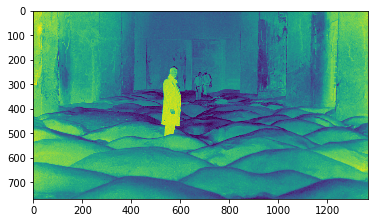

In [56]:
cymk = rgb_to_cmyk(img)
plt.imshow(cymk[:,:,-1])

In [57]:
cymk = rgb_to_cmyk(img)
# cc = interpolate.interp2d(x, y, cymk[:,:,0].flatten(), kind='linear')
# yc = interpolate.interp2d(x, y, cymk[:,:,1].flatten(), kind='linear')
# mc = interpolate.interp2d(x, y, cymk[:,:,2].flatten(), kind='linear')
x = np.linspace(0,img.shape[0],img.shape[0])
y = np.linspace(0,img.shape[1],img.shape[1])
kc = interpolate.interp2d(x, y, cymk[:,:,3].flatten(), kind='linear')
# c_lines = grid_lineify(cc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
# y_lines = grid_lineify(yc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 500)
# m_lines = grid_lineify(mc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]),ntraj = 1000)
k_lines = grid_lineify(kc, x_lim=(0, img.shape[0]), y_lim=(0, img.shape[1]), 
            ntraj = 1500, 
            max_step = 4000, gamma = 0.08, dt = 9., e0 = 0.03, 
            T = 0.1, e_thresh = 0.006, h = 2e-1, m = 6, bounce = False)

In [61]:
with open("stalkerII",'wb') as f: 
    pickle.dump(k_lines,f)

In [60]:
write_svg(k_lines, scale=3.0)

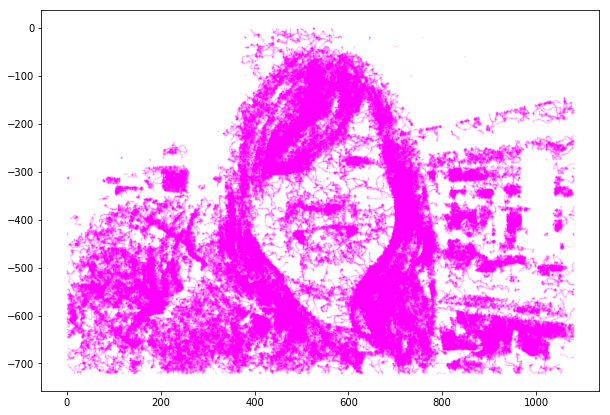

In [1117]:
plt.figure(figsize=(10,7))
# for line in c_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='cyan')
# for line in y_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='yellow')
# for line in m_lines: 
#     if (len(line)<1):
#         continue 
#     t1 = np.array(line)
#     _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.5, color='magenta')
for line in k_lines: 
    if (len(line)<1):
        continue 
    t1 = np.array(line)
    _ = plt.scatter(t1[:,1], -t1[:,0], s=1,alpha=0.1, color='magenta')    
plt.show()

In [190]:
pl = Plotter()

Initializing I2C... 
Initializing pen...
Move pen to start and press ENTER.

Print area:  (2.0, 89.44) (2.0, 57.2)
Step Lengt:  0.15707963267948966
Min Resolu:  556.0  X  351.0
Line Files:
10 stalkerlines.pkl
--- Selection ---
10
Load Pen.
Initializing pen...
Move pen to start and press ENTER.

Data Bounds:  [0.021159459344625514, 0.004511756825272828, 802.9934998713557, 999.9992398531366]
Scaling Data....
Scaled Data. [23.779468102211165, 2.2759999999999962, 67.66053189778883, 56.92400000000001]
Planning  36  paths.
drawing...
Drawing  5  vertices 
took  7.434473276138306 s
Drawing  98  vertices 
took  3.4249379634857178 s
Drawing  83  vertices 
took  2.6103789806365967 s
Drawing  57  vertices 
took  1.49593186378479 s
Drawing  154  vertices 
took  4.452978849411011 s
Drawing  1274  vertices 
took  18.930482149124146 s
Drawing  1583  vertices 
took  19.24885392189026 s
Drawing  55  vertices 
took  1.838973045349121 s
Drawing  8  vertices 
took  1.1161220073699951 s
Drawing  342  verti

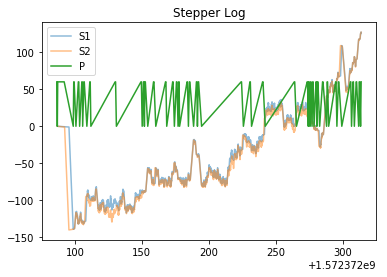

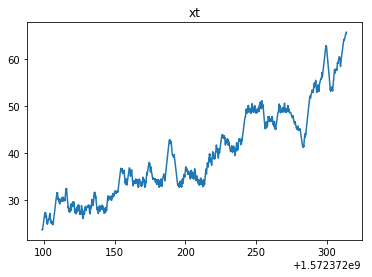

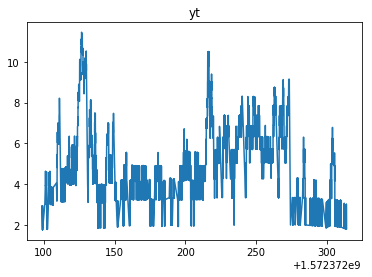

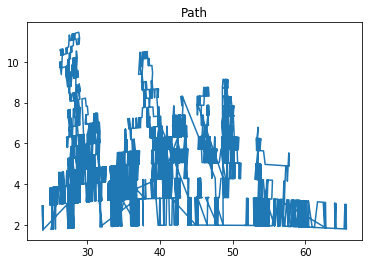

In [191]:
pl.plot_paths()